In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [23]:
df = pd.read_pickle('/home/niell_lab/data/freely_moving_ephys/batch_files/081721/pooled_ephys_unit_update_081721.pickle')

In [24]:
df['session'].unique()

array(['012521_EE8P6LT_control_Rig2', '012821_EE8P6LT_control_Rig2',
       '021621_EE11P1LT_control_Rig2', '030921_EE11P13LTRN_control_Rig2',
       '031021_EE11P13LTRN_control_Rig2', '053121_J552NC_control_Rig2',
       '060221_J552NC_control_Rig2', '062221_G6H31P2RT_control_Rig2',
       '062321_G6H31P2RT_control_Rig2', '062421_G6H31P2RT_control_Rig2',
       '062921_G6HCK1ALTRN_control_Rig2',
       '063021_G6HCK1ALTRN_control_Rig2', '070621_J553LT_control_Rig2',
       '070921_J553RT_control_Rig2', '071021_J553RT_control_Rig2', nan],
      dtype=object)

In [25]:
df1 = df[df['session']=='070921_J553RT_control_Rig2']

In [26]:
eyeT = df1['fm1_eyeT'].iloc[0]

In [27]:
dEye = df1['fm1_dEye'].iloc[0]

In [28]:
dhead = df1['fm1_dHead'].iloc[0]

In [29]:
dgz = dEye + dhead(eyeT[0:-1])

In [30]:
goodcells = df1.copy()

In [55]:
trange = np.arange(-1,1.1,0.025)
print('comp head movemements')
for sthresh in [2,3,5,7.5]:
    upsacc = eyeT[(np.append(dhead(eyeT[0:-1]),0)>sthresh) & (np.append(dgz,0)<1)]
    downsacc = eyeT[(np.append(dhead(eyeT[0:-1]),0)<-sthresh) & (np.append(dgz,0)>-1)]
    print('sthresh=',sthresh,'up:',len(upsacc),'down:',len(downsacc))

comp head movemements
sthresh= 2 up: 4629 down: 4326
sthresh= 3 up: 1984 down: 1528
sthresh= 5 up: 363 down: 220
sthresh= 7.5 up: 46 down: 32


In [65]:
trange = np.arange(-1,1.1,0.025)
sthresh = 5
upsacc = eyeT[(np.append(dhead(eyeT[0:-1]),0)>sthresh) & (np.append(dgz,0)>sthresh)]
downsacc = eyeT[(np.append(dhead(eyeT[0:-1]),0)<-sthresh) & (np.append(dgz,0)<-sthresh)]

In [66]:
def plot_saccade_locked(goodcells, upsacc, downsacc, trange):
    """
    plot average eye movements in window
    upsacc and downsacc can be filtered ahead of time so only include times when e.g. dHead crosses threshold
    INPUTS
        goodcells: ephys dataframe
        upsacc: eye timestamps when there is an eye movement in the positive direction (left)
        downsacc: eye timestamps when there is an eye movement in the negative direction (right)
        trange: time window to plot
    OUTPUTS
        upsacc_avg: trace of average saccade to the left
        downsacc_avg: trace of average saccade to the right
        fig: figure
    """
    n_units = len(goodcells)
    upsacc_avg = np.zeros((n_units,trange.size-1))
    downsacc_avg = np.zeros((n_units,trange.size-1))
    fig = plt.subplots(np.ceil(n_units/7).astype('int'),7,figsize=(35,np.int(np.ceil(n_units/3))),dpi=50)
    for i, ind in enumerate(goodcells.index):
        for s in np.array(upsacc):
            hist, edges = np.histogram(goodcells.at[ind,'fm1_spikeT']-s, trange)
            upsacc_avg[i,:] = upsacc_avg[i,:] + hist / (upsacc.size*np.diff(trange))
        for s in np.array(downsacc):
            hist,edges = np.histogram(goodcells.at[ind,'fm1_spikeT']-s,trange)
            downsacc_avg[i,:] = downsacc_avg[i,:]+ hist/(downsacc.size*np.diff(trange))
        plt.subplot(np.ceil(n_units/7).astype('int'),7,i+1)
        plt.plot(0.5*(trange[0:-1] + trange[1:]), upsacc_avg[i,:])
        plt.plot(0.5*(trange[0:-1] + trange[1:]), downsacc_avg[i,:],'r')
        maxval = np.max(np.maximum(upsacc_avg[i,:], downsacc_avg[i,:]))
        plt.vlines(0,0,np.max(upsacc_avg[i,:]*0.2), 'r')
        plt.xlim([-0.5, 0.5])
        if maxval < 2:
            plt.ylim([0,2])
        else:
            plt.ylim([0,maxval*1.2])
        plt.ylabel('sp/sec')
    plt.tight_layout()
    return upsacc_avg, downsacc_avg, fig

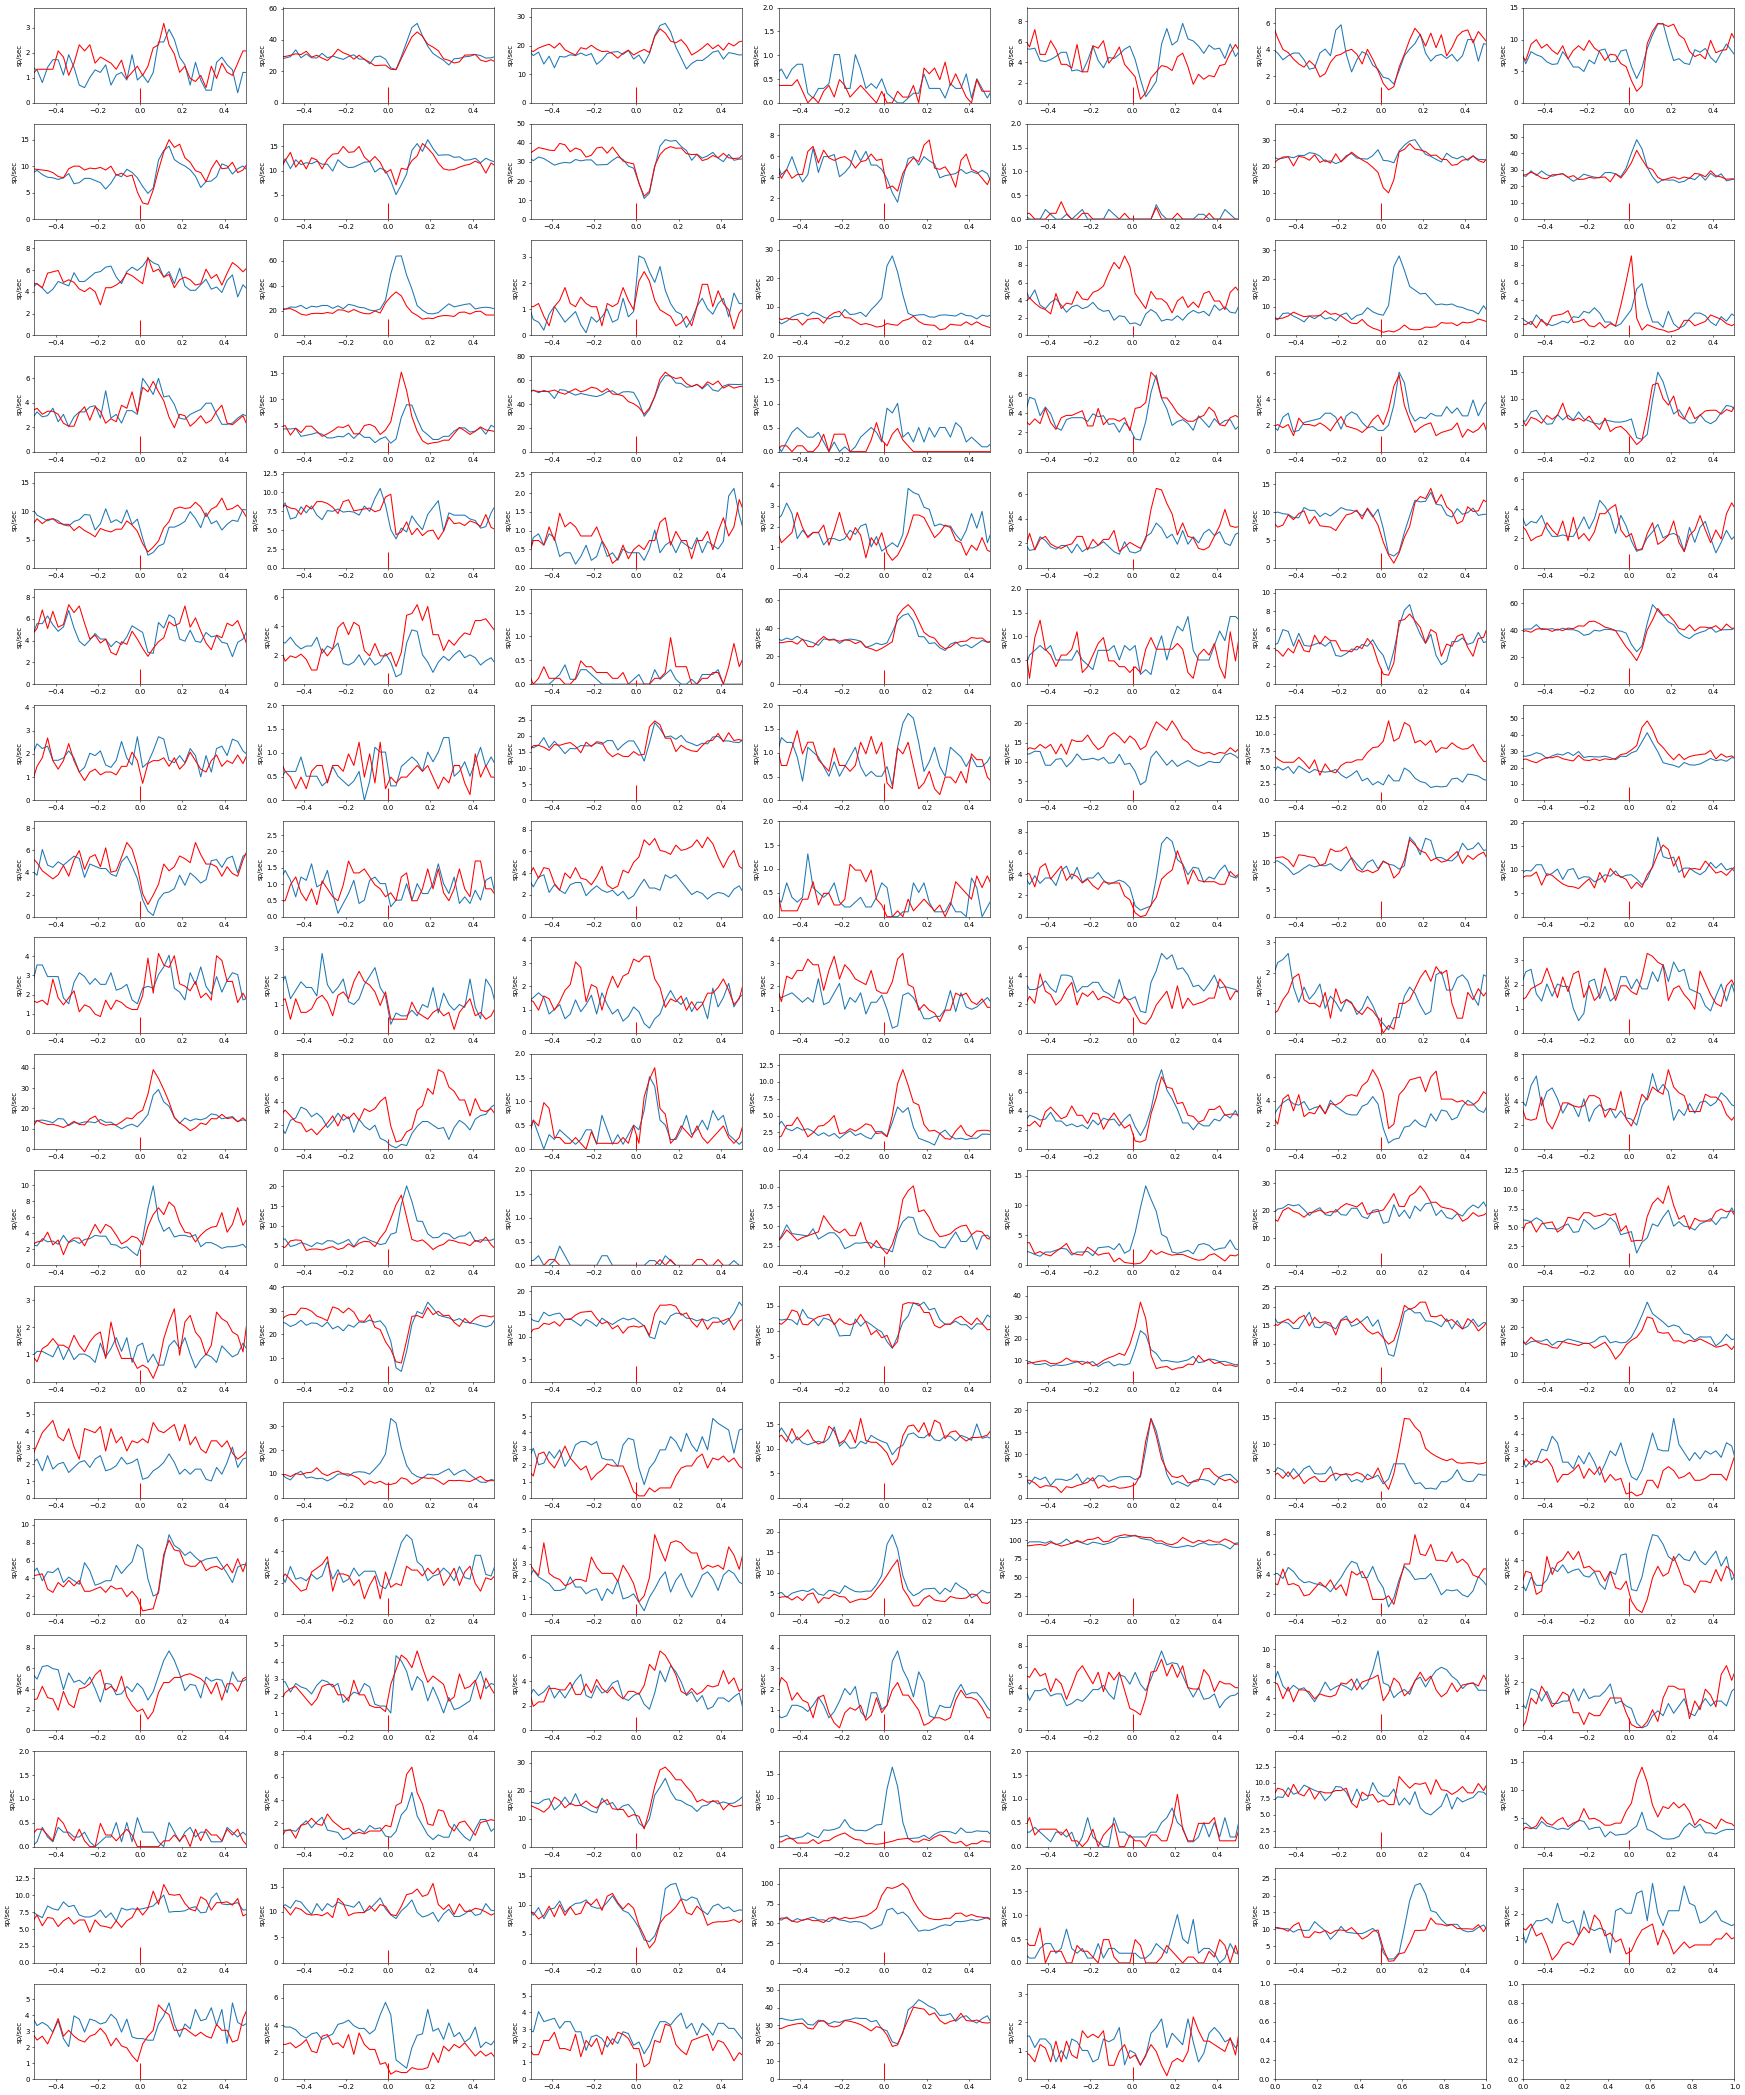

In [67]:
upsacc_avg_gaze_shift_dEye, downsacc_avg_gaze_shift_dEye, saccade_lock_fig = plot_saccade_locked(goodcells, upsacc,  downsacc, trange)